In [1]:
import numpy as np
import re

In [2]:
# ロードしたデータを訓練データ用のStringと正解ラベルに分ける
def split_vector(data):
    dic = {'b':0, 't':1, 'e':2, 'm':3}
    y = np.zeros(len(data) - 1)
    x = []
    for i, d in enumerate(data):
        if i == len(data) - 1:
            break
        y[i] = dic[d[0]]
        x.append(d[1])
    
    return (x, y.astype(np.uint8))

In [3]:
# 70
file_path = 'data/NewsAggregatorDataset/'

with open(file_path + 'train.txt') as f:
    train_data = f.read().split('\n')
x_train, y_train = split_vector([d.split('\t') for d in train_data])
print(len(x_train), y_train.shape)

with open(file_path + 'test.txt') as f:
    test_data = f.read().split('\n')
x_test, y_test = split_vector([d.split('\t') for d in test_data])
print(len(x_test), y_test.shape)

with open(file_path + 'valid.txt') as f:
    valid_data = f.read().split('\n')
x_valid, y_valid = split_vector([d.split('\t') for d in valid_data])
print(len(x_valid), y_valid.shape)

8708 (8708,)
1089 (1089,)
1088 (1088,)


In [4]:
from gensim.models import KeyedVectors
news_path = 'data/GoogleNews-vectors-negative300.bin'
words = KeyedVectors.load_word2vec_format(news_path, binary = True)

In [5]:
def vec2sum(x_data, dim):
    pattern = re.compile(r'[a-z|A-Z]+', re.MULTILINE + re.VERBOSE)  
    vector_sum = np.zeros((len(x_data), dim))
    for i, s in enumerate(x_data):
        vector = np.zeros(dim) 
        cnt = 0
        ss = pattern.findall(s)
        for noun in ss:
            try :
                cnt += 1
                vector += words[noun]
            except KeyError as error:
                continue
        if cnt == 0:
            continue
        vector_sum[i] = (vector / cnt)

    return vector_sum

In [6]:
x_feature = vec2sum(x_train, 300)
print(len(x_train))
print(x_feature.shape)


8708
(8708, 300)


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as func
import torch.optim as optim
from torch.autograd import Variable
dim = words['US'].shape[0] # 単語ベクトルの次元

In [8]:
# 71
w = torch.randn(dim, 4, requires_grad = True)
x_feature = torch.tensor(x_feature, requires_grad = True)
y = func.softmax(torch.matmul(x_feature[:1].float(), w))

print(y)


tensor([[0.1806, 0.1642, 0.3553, 0.2999]], grad_fn=<SoftmaxBackward>)


/Users/taimu/yes/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.


In [9]:
# 複数事例
Y = func.softmax(torch.mm(x_feature[:4].float(), w), dim = 1)
print(Y)

tensor([[0.1806, 0.1642, 0.3553, 0.2999],
        [0.0595, 0.5623, 0.2782, 0.1000],
        [0.1504, 0.2301, 0.5477, 0.0718],
        [0.2057, 0.4193, 0.1192, 0.2558]], grad_fn=<SoftmaxBackward>)


In [10]:
from math import exp, log

criterion = nn.CrossEntropyLoss()
y_train = torch.tensor(y_train.astype(float), requires_grad = True)

# 単体事例
y_ = criterion(torch.mm(x_feature[:1].float(), w), y_train[:1].long())
print(y_)
y_.backward()
print(w.grad)

# 複数事例
Y_ = criterion(torch.mm(x_feature[:4].float(), w), y_train[:4].long())
print(Y_)
Y_.backward()
print(w.grad)

# 検算
ans = []
for yy, i in zip(Y, y_train[:4].long()):
    ans.append(-log(yy[i]))
print(sum(ans) / len(ans))

tensor(1.0347, grad_fn=<NllLossBackward>)
tensor([[-0.0030, -0.0028,  0.0108, -0.0050],
        [ 0.0201,  0.0183, -0.0718,  0.0334],
        [-0.0023, -0.0021,  0.0083, -0.0039],
        ...,
        [-0.0155, -0.0141,  0.0555, -0.0258],
        [-0.0058, -0.0053,  0.0208, -0.0097],
        [-0.0027, -0.0024,  0.0095, -0.0044]])
tensor(1.4555, grad_fn=<NllLossBackward>)
tensor([[-0.0239,  0.0244,  0.0094, -0.0099],
        [-0.0029,  0.0440, -0.0921,  0.0511],
        [ 0.0104, -0.0117,  0.0077, -0.0063],
        ...,
        [-0.0250,  0.0001,  0.0706, -0.0457],
        [-0.0054, -0.0003,  0.0232, -0.0175],
        [ 0.0152, -0.0095,  0.0158, -0.0214]])
1.4555362877818967


In [11]:
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
class MyNet(nn.Module):
    def __init__(self, input_size):
        super(MyNet, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, 4)
        
    def forward(self, x):
        x = self.fc1(x)
        return x

In [13]:
mynet = MyNet(dim)
optimizer = optim.SGD(mynet.parameters(), lr = 0.01, momentum = 0.9)
num_epochs = 100
save_path = '../data/params.tar'

In [14]:
class Model():
    def __init__(self, model):
        self.model = model
        
    def set_params(self, num_epochs, num_batches, optimizer, criterion, x_valid, y_valid):
        # エポック数，バッチサイズ，最適化アルゴリズム，損失関数の初期化
        self.num_epochs = num_epochs
        self.num_batches = num_batches
        self.optimizer = optimizer
        self.criterion = criterion
        self.x_valid = torch.tensor(x_valid).float()
        self.y_valid = torch.tensor(y_valid).long()
        
        # epoch毎の損失と精度を保持するリスト
        self.train_score = np.zeros(num_epochs)        
        self.train_loss = np.zeros(num_epochs)
        self.valid_score = np.zeros(num_epochs)
        self.valid_loss = np.zeros(num_epochs)

    def fit(self, x_train, y_train):
        num_data = x_train.shape[0]
        for epoch in range(self.num_epochs):

            # epoch毎の損失と精度
            running_loss = 0.0
            accuracy = 0.0

            # 開始時間
            t = time.time()

            # ミニバッチ学習のために訓練データのインデックスをランダムに並べ替える
            index = np.random.permutation(num_data)

            for i in range(0, num_data, self.num_batches):
                # NNへの入力と正解ラベル
                in_, label = torch.tensor(x_train[index[i : i + self.num_batches if i + self.num_batches < num_data else num_data]]), \
                             torch.tensor(y_train[index[i : i + self.num_batches if i + self.num_batches < num_data else num_data]]).long()

                # 最適化関数の初期化
                self.optimizer.zero_grad()

                # 予測とロスの計算
                out_ = self.model(in_.float())
                loss = self.criterion(out_, label)
                _, idx = torch.max(out_, 1)

                # バッチ数のラベルより正解数のカウント
                accuracy += (np.sum(idx.numpy() == label.numpy()) / idx.shape[0])

                # パラメーターの更新
                loss.backward()
                optimizer.step()
                running_loss += loss.data
                
            out_ = self.model(self.x_valid)
            _, idx = torch.max(out_, 1)
            v_accuracy = self.evaluate(self.x_valid, self.y_valid)
            v_loss = self.criterion(out_, self.y_valid)
            v_loss.backward()

            # 各種データの出力・保存
            num_loop = num_data / self.num_batches
            accuracy /= num_loop
            loss = running_loss / num_loop
            print('[ epoch:{0}, time:{3} ]  acc: {1:.4f}  loss:{2:.4f}'.format(epoch + 1, accuracy, loss, time.time() - t))
            self.train_score[epoch] = accuracy
            self.train_loss[epoch] = loss
            self.valid_score[epoch] = v_accuracy
            self.valid_loss[epoch] = v_loss.data

 
            # 状況の保存
            torch.save({
              'epoch': epoch,
              'model_state_dict': self.model.state_dict(),
              'optimizer_state_dict': self.optimizer.state_dict(),
              'loss': loss,
              'accuracy': accuracy,
              }, save_path)
    
    def predict(self, x):
        out_ = self.model(x)
        return out_
    
    def evaluate(self, x, y):
        p = self.predict(x)
        _, idx = torch.max(p, 1)
        accuracy = np.sum(idx.numpy() == y.numpy()) / idx.shape[0]
        
        return accuracy
    
    def visualize(self):
        x = np.arange(len(self.train_score))
        fig = plt.figure()
        ax = fig.add_subplot(211)
        ax.plot(x, self.train_score, color = 'red', linewidth = 2, label = 'train_score')
        ax.plot(x, self.valid_score, color = 'blue', linewidth = 1, label = 'valid_score', linestyle = 'dashed')

        ax2 = fig.add_subplot(212)
        ax2.plot(x, self.train_loss, color = 'green', linewidth = 2, label = 'train_loss')
        ax2.plot(x, self.valid_loss, color = 'blue', linewidth = 1, label = 'valid_loss', linestyle = 'dashed')
        ax.legend()
        ax2.legend()
        plt.plot()
    

In [15]:
model = Model(mynet)
model.set_params(num_epochs, 16, optimizer, criterion, vec2sum(x_valid, dim), y_valid)

In [16]:
model.fit(x_feature, y_train)

/Users/taimu/yes/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/Users/taimu/yes/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[ epoch:1, time:0.19979095458984375 ]  acc: 0.7901  loss:0.7395
[ epoch:2, time:0.22914886474609375 ]  acc: 0.8273  loss:0.5138
[ epoch:3, time:0.21206021308898926 ]  acc: 0.8485  loss:0.4409
[ epoch:4, time:0.21294784545898438 ]  acc: 0.8674  loss:0.3986
[ epoch:5, time:0.2129840850830078 ]  acc: 0.8799  loss:0.3698
[ epoch:6, time:0.21240520477294922 ]  acc: 0.8892  loss:0.3494
[ epoch:7, time:0.21036005020141602 ]  acc: 0.8937  loss:0.3340
[ epoch:8, time:0.21610808372497559 ]  acc: 0.8976  loss:0.3220
[ epoch:9, time:0.21641111373901367 ]  acc: 0.9010  loss:0.3129
[ epoch:10, time:0.2149200439453125 ]  acc: 0.9025  loss:0.3038
[ epoch:11, time:0.22524690628051758 ]  acc: 0.9050  loss:0.2970
[ epoch:12, time:0.22061514854431152 ]  acc: 0.9078  loss:0.2913
[ epoch:13, time:0.21181893348693848 ]  acc: 0.9078  loss:0.2864
[ epoch:14, time:0.21261191368103027 ]  acc: 0.9099  loss:0.2825
[ epoch:15, time:0.21867704391479492 ]  acc: 0.9112  loss:0.2770
[ epoch:16, time:0.23090600967407227

In [17]:
model.evaluate(x_feature.float(), torch.tensor(y_train))

/Users/taimu/yes/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


0.9299494717501149

In [18]:
model.evaluate(torch.tensor(vec2sum(x_valid, dim), requires_grad = True).float(), torch.tensor(y_valid))

0.9246323529411765

In [19]:
model.evaluate(torch.tensor(vec2sum(x_test, dim), requires_grad = True).float(), torch.tensor(y_test))

0.9439853076216712

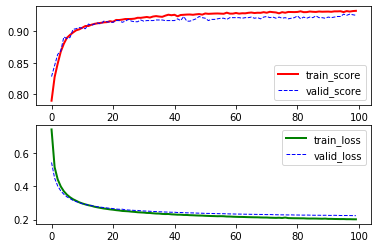

In [20]:
model.visualize()

In [21]:
model2 = Model(mynet)
model2.set_params(num_epochs, 4, optimizer, criterion, vec2sum(x_valid, dim), y_valid)

In [22]:
model2.fit(x_feature, y_train)

/Users/taimu/yes/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/Users/taimu/yes/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[ epoch:1, time:0.6712989807128906 ]  acc: 0.9296  loss:0.2029
[ epoch:2, time:0.7032830715179443 ]  acc: 0.9297  loss:0.2019
[ epoch:3, time:0.7054562568664551 ]  acc: 0.9299  loss:0.2007
[ epoch:4, time:0.707669734954834 ]  acc: 0.9298  loss:0.1998
[ epoch:5, time:0.6924247741699219 ]  acc: 0.9303  loss:0.1990
[ epoch:6, time:0.7187838554382324 ]  acc: 0.9305  loss:0.1981
[ epoch:7, time:0.7493162155151367 ]  acc: 0.9318  loss:0.1970
[ epoch:8, time:0.7304482460021973 ]  acc: 0.9308  loss:0.1966
[ epoch:9, time:0.7042572498321533 ]  acc: 0.9321  loss:0.1956
[ epoch:10, time:0.7345411777496338 ]  acc: 0.9318  loss:0.1948
[ epoch:11, time:0.7207117080688477 ]  acc: 0.9327  loss:0.1941
[ epoch:12, time:0.7573330402374268 ]  acc: 0.9324  loss:0.1932
[ epoch:13, time:0.6969561576843262 ]  acc: 0.9333  loss:0.1928
[ epoch:14, time:0.6941943168640137 ]  acc: 0.9332  loss:0.1919
[ epoch:15, time:0.6937708854675293 ]  acc: 0.9337  loss:0.1915
[ epoch:16, time:0.6994380950927734 ]  acc: 0.9345

In [23]:
class MyNet2(nn.Module):
    def __init__(self, input_size, h_size, output_size):
        super(MyNet2, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, h_size)
        self.fc2 = torch.nn.Linear(h_size, int(h_size / 2))
        self.fc3 = torch.nn.Linear(int(h_size / 2), output_size)
        
    def forward(self, x):
        x = self.fc1(x)
        x = func.relu(x)
        x = self.fc2(x)
        x = func.relu(x)
        x = self.fc3(x)
        return x

In [24]:
mynet = MyNet2(dim, 100, 4)
optimizer = optim.SGD(mynet.parameters(), lr = 0.01, momentum = 0.9)
criterion = torch.nn.CrossEntropyLoss()
save_path = '../data/params.tar'

model = Model(mynet)
model.set_params(num_epochs, 2, optimizer, criterion, vec2sum(x_valid, dim), y_valid)

In [ ]:
model.fit(x_feature, y_train)

/Users/taimu/yes/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/Users/taimu/yes/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[ epoch:1, time:2.714562177658081 ]  acc: 0.8511  loss:0.4141
[ epoch:2, time:2.7528021335601807 ]  acc: 0.9099  loss:0.2652
[ epoch:3, time:2.709635019302368 ]  acc: 0.9181  loss:0.2313
[ epoch:4, time:2.730846881866455 ]  acc: 0.9212  loss:0.2175
[ epoch:5, time:2.64666485786438 ]  acc: 0.9267  loss:0.1999
[ epoch:6, time:2.613356590270996 ]  acc: 0.9305  loss:0.1868
[ epoch:7, time:2.618211269378662 ]  acc: 0.9353  loss:0.1793
[ epoch:8, time:2.604094982147217 ]  acc: 0.9393  loss:0.1616
[ epoch:9, time:2.6057159900665283 ]  acc: 0.9443  loss:0.1527
[ epoch:10, time:2.610842227935791 ]  acc: 0.9445  loss:0.1453
[ epoch:11, time:2.598304033279419 ]  acc: 0.9496  loss:0.1303
[ epoch:12, time:2.6054847240448 ]  acc: 0.9540  loss:0.1230
[ epoch:13, time:2.649444818496704 ]  acc: 0.9580  loss:0.1149
[ epoch:14, time:2.7256112098693848 ]  acc: 0.9596  loss:0.1037
[ epoch:15, time:2.8109450340270996 ]  acc: 0.9613  loss:0.1016
[ epoch:16, time:2.7816641330718994 ]  acc: 0.9661  loss:0.0870

In [ ]:
model.evaluate(x_feature.float(), torch.tensor(y_train))
model.evaluate(torch.tensor(vec2sum(x_valid, dim), requires_grad = True).float(), torch.tensor(y_valid))

In [ ]:
model.visualize()